# Tasks

1. Go through all predictions per scene
2. Take a sliding window of size 5
3. Transform all BEVS to frame of the current one
4. Only consider all the 







Okay consider the following - you have 5 images, each of which is a partial occupancy map, this is a key difference between 

In [1]:
import os
import numpy as np
import quaternion
import matplotlib.pyplot as plt
import cv2
import sys
import random
import torch
import kornia

from matplotlib import colors

PROJ_DIR = os.path.dirname(os.path.abspath('.'))
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

from utils.layout_utils import mean_IU, mean_precision

#Increase matplotlib font
plt.rcParams.update({'font.size': 14})

# Evaluation Paths

In [2]:
model_output = dict()

# model_output["occant_rgb_vo"] = '/scratch/shantanu/results/occant_rgb_vo/dump/0/{}/0/pred_visible_occupancy/{}.png'
# model_output["ans_rgb_vo"] = '/scratch/shantanu/results/ans_rgb_vo/dump/0/{}/0/left_bevpred/{}.png'
# model_output["ans_rgb_vo41"] = '/scratch/shantanu/results/ans_rgb_vo41/dump/0/{}/0/left_bevpred/{}.png'
# model_output["ans_rgb_vo41_ep5"] = '/scratch/shantanu/results/ans_rgb_vo41_ep5/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_rgb"] = '/scratch/shantanu/results_21022022/occant_rgb/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_rgbd"] = '/scratch/shantanu/results/occant_rgbd/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_depth"] = '/scratch/shantanu/results/occant_depth/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_lstm"] = '/scratch/shantanu/results/occant_lstm/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_concat"] = '/scratch/shantanu/results/occant_concat/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_semantics"] = '/scratch/shantanu/results/occant_semantics/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_auxsemantics"] = '/scratch/shantanu/results/occant_auxsemantics/dump/0/{}/0/left_bevpred/{}.png'

# model_output["depthraw"] = '/scratch/shantanu/results/depthraw/dump/0/{}/0/left_bevpred/{}.png'
# model_output["chandrakar"] = '/scratch/shantanu/results/chandrakar2/{}/0/pred_bev/{}.png'
# model_output["chandrakarbev"] = '/scratch/shantanu/results/chandrakarbev/dump/0/{}/0/left_bevpred/{}.png'
# model_output["chandrakardepth"] = '/scratch/shantanu/results/chandrakarbev/dump/0/{}/0/left_bevpred/{}.png'
# model_output["maskeddepth"] = '/scratch/shantanu/results/maskeddepth/dump/0/{}/0/left_bevpred/{}.png'
# model_output["crossview"] = '/scratch/shantanu/crossview/model_outputs/pred/{}/{}.png'

# model_output["chandrakr_bev"] = '/scratch/shantanu/gibson4/chandrakar_g4/{}/0/{}/pred_bev/{}.png'
# model_output["chandrakr_depth"] = '/scratch/shantanu/gibson4/chandrakar_g4/{}/0/{}/pred_depth/{}.png'
# model_output["ans_rgb"] = '/scratch/shantanu/results_24022022/ans_rgb/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_rgb"] = '/scratch/shantanu/results_24022022/occant_rgb/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_rgbd"] = '/scratch/shantanu/results_24022022/occant_rgbd/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_ckdepth"] = '/scratch/shantanu/results_24022022/occant_ckdepth/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_ckbev"] = '/scratch/shantanu/results_24022022/occant_ckbev/dump/0/{}/{}/bev_pred/{}.png'
# model_output["basic_transformer"] = '/scratch/shantanu/results_24022022/basic_transformer/{}/{}/{}.png'
# model_output["bt_ckdepth_preattn"] = '/scratch/shantanu/results_24022022/ckdepth_resnet/{}/{}/{}.png'

model_output["ans_rgb"] = '/scratch/shantanu/final_results/hm3d/ans_rgb/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_rgb"] = '/scratch/shantanu/final_results/hm3d/occant_rgb/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_rgbd"] = '/scratch/shantanu/final_results/hm3d/occant_rgbd/dump/0/{}/{}/bev_pred/{}.png'
model_output["basic_transformer"] = '/scratch/shantanu/final_results/hm3d/basic_transformer/{}/{}/{}.png'

In [25]:
base_dir = '/scratch/shantanu/new/'

gt_rgb = base_dir + '{}/0/{}/RGB/{}.jpg'
gt_depth = base_dir + '{}/0/{}/DEPTH/{}.png'
# gt_semantics = '/scratch/shantanu/gibson4/semantics/{}/0/{}/semantics/{}.png'
gt_bev = base_dir + '{}/0/{}/map/{}.png'
gt_pose = base_dir + '{}/0/{}/pose/{}.npy'

gt_po = '/scratch/shantanu/partial_maps/new_partialmaps_120/{}/{}/partial_occ/{}.png'

# gt_vo = '/scratch/shantanu/gibson4/visible_occupancy/{}/0/{}/vo/{}.png'

In [26]:
val_split_file = '../splits/gibson4/filtered_front_val_files.txt'
with open(val_split_file, 'r') as f:
    val_fps = f.read().splitlines()
    
val_fps[:5]

['Pablo front 0',
 'Pablo front 1',
 'Pablo front 2',
 'Pablo front 3',
 'Pablo front 4']

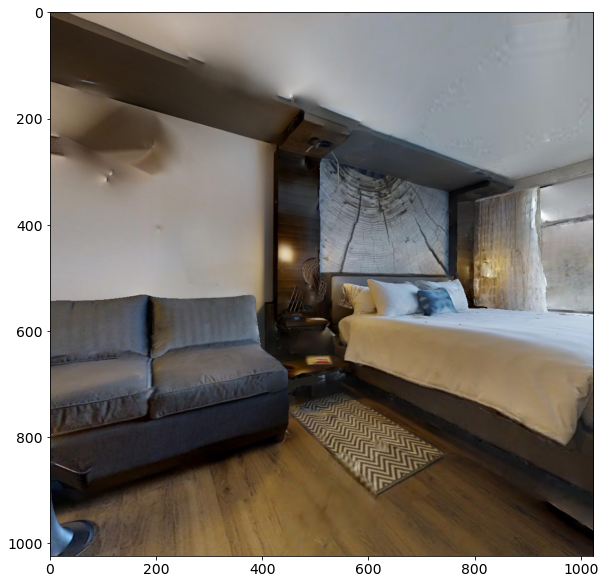

In [27]:
fig = plt.figure(figsize=(20, 10))

rgb_img = cv2.cvtColor(cv2.imread(gt_rgb.format(*val_fps[0].split()), -1), cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

# Qualitative

View few frame runs from val split

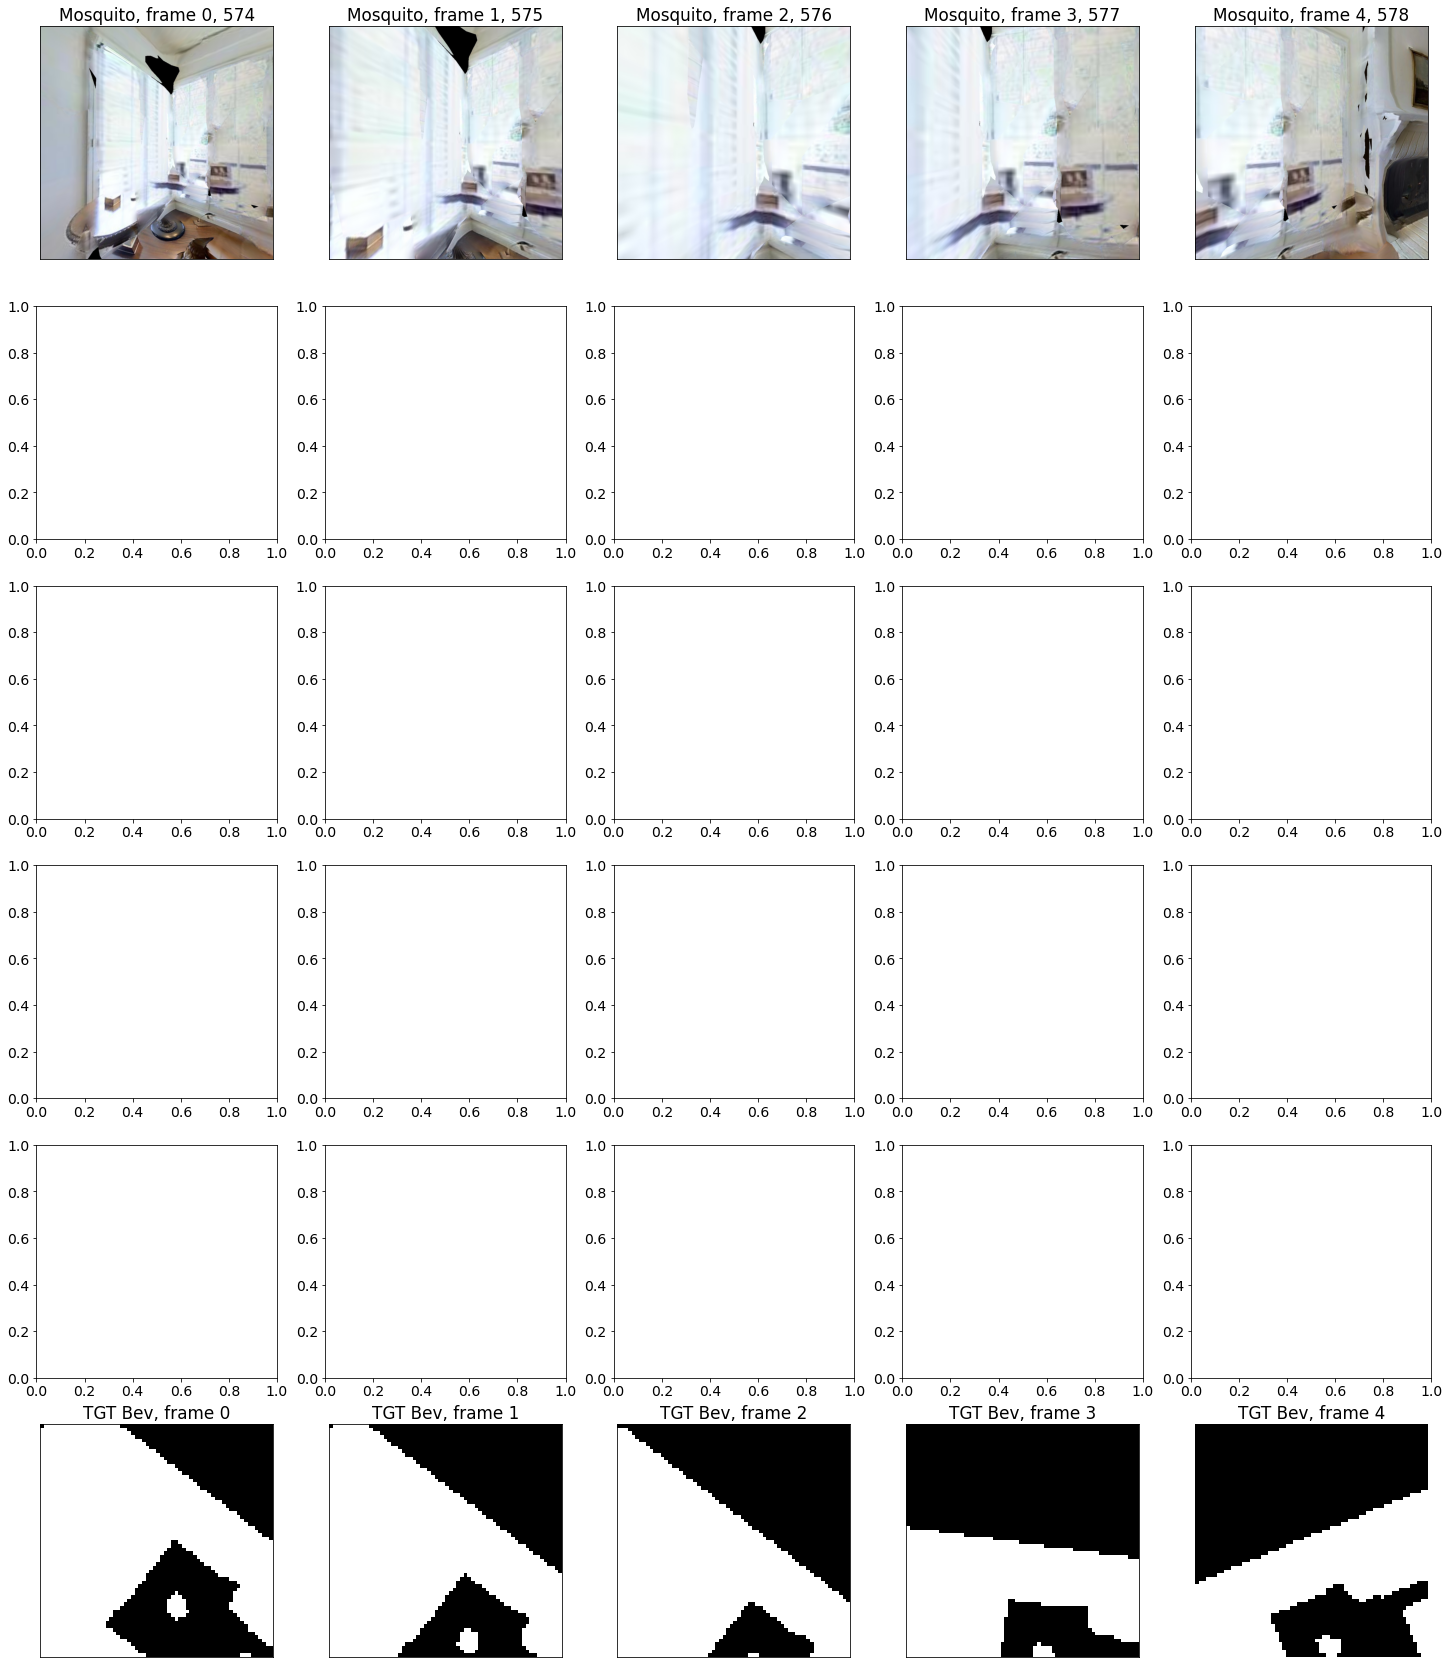

In [28]:
nrows = 2 + len(model_output)
ncols = 5 # Frame Count

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols, 5*nrows))

random.shuffle(val_fps)

scene, pose, fileidx = val_fps[0].split() # Take a random scene, and starting position

# Set the RGB row first and GT BEv row last
for col_idx in range(ncols):
    
    fileidx = int(fileidx)
    
    rgb_fp = gt_rgb.format(scene, pose, fileidx + col_idx)
    rgb_img = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
    ax[0][col_idx].imshow(rgb_img)
    ax[0][col_idx].set_title(f'{scene}, frame {col_idx}, {fileidx + col_idx}')
    ax[0][col_idx].set_xticks([])
    ax[0][col_idx].set_yticks([])    
    
    tgtbev_fp = gt_bev.format(scene, pose, fileidx + col_idx)    
    tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
    tgtbev_img[0, 0] = 0
    ax[nrows - 1][col_idx].imshow(tgtbev_img, cmap='gray')
    ax[nrows - 1][col_idx].set_title(f'TGT Bev, frame {col_idx}')
    ax[nrows - 1][col_idx].set_xticks([])
    ax[nrows - 1][col_idx].set_yticks([])
    
#     for idx, model_name in enumerate(model_output):
#         model_fp = model_output[model_name].format(scene, pose, fileidx + col_idx)
#         model_img = cv2.imread(model_fp, -1)

#         # Map 0 (Unknown) -> 127 to be consistent with GT Bev
#         if model_name in ['Occupancy Anticipation']:
#             model_img[model_img == 0] = 127

#         model_img[0, 0] = 0 # to ensure every image has zero label for plotting

#         ax[idx+1][col_idx].imshow(model_img, interpolation='nearest')
#         ax[idx+1][col_idx].set_title(model_name)
    ax[0][col_idx].set_xticks([])
    ax[0][col_idx].set_yticks([])    

        
plt.axis('off')
plt.xticks([], [])
plt.show()

# Quantitative

In [58]:
def read_rgb(i, scene):
    tgtrgb_fp = gt_rgb.format(scene, "front", i)
    tgtrgb_img = cv2.cvtColor(cv2.imread(tgtrgb_fp, -1), cv2.COLOR_BGR2RGB)
    
    return tgtrgb_img

In [43]:
def read_bev(i, scene):
    tgtbev_fp = gt_po.format(scene, "front", i)    
#     print(tgtbev_fp)
    tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
    tgtbev_img[0, 0] = 0
    
    return tgtbev_img

In [44]:
def read_pose(i, scene):
    gt_pose_fp = gt_pose.format(scene, "front", i)
    pose = np.load(gt_pose_fp, allow_pickle=True).item()
    
    return pose 

In [45]:
# def make_T_matrix(pose0):
    
#     quat0 = pose0['rotation']
#     t0 = pose0['position']
#     T0 = np.eye(4)
#     T0[:3,:3] = quaternion.as_rotation_matrix(quat0)
#     T0[:3,3] = t0 # (resolution is 5 cm per cell)
    
#     upper_left_T = np.eye(4)
#     upper_left_T[0, -1] = -1.6
#     upper_left_T[2, -1] = 3.2
        
#     T0 = T0 @ upper_left_T
    
#     T0[:3, 3] *= 100 // 5
    
# #     T2D = np.eye(3)
# #     T2D[:2, :2] = T0[:3, :3][::2, ::2]
# #     T2D[:2, 2] = T0[:3, 3][::2] * 100 // 5 # (resolution is 5 cm per cell)
        
#     return T0

In [46]:
# def transform_bev(bev0, bev1, pose0, pose1):
        
#     T0w = make_T_matrix(pose0) # T_0^w- 3D frame of camera
#     T1w = make_T_matrix(pose1) # T_1^w - 3D frame of camera
    
#     T0w_upperleft = T0w
#     T1w_upperleft = T1w
    
#     Tw0_upperleft = np.linalg.inv(T0w_upperleft) # T_w^0 - 3D frame of camera
    
#     T01_upperleft = Tw0_upperleft @ T1w_upperleft # T_w^0 x T_1^w = T_1^0 - 3D frame of camera
        
#     T01_im =  np.eye(3) # Drop the Y axis - 2D frame of camera
#     T01_im[:2, :2] = T01_upperleft[:3, :3][::2, ::2]
#     T01_im[:2, 2] = T01_upperleft[:, -1][::2]
                
#     T01_im[0, :] *= -1

#     return T01_im

In [52]:
def make_T_matrix(pose0):
    
    quat0 = pose0['rotation']
    t0 = pose0['position']
    T0 = np.eye(4)
    T0[:3,:3] = quaternion.as_rotation_matrix(quat0)
    T0[:3,3] = t0 
    T0[:3, 3] = T0[:3, 3] // 0.05 # (resolution is 5 cm per cell)
        
    return T0

def get_T_upperleft():
    upper_left_T = np.eye(4)
    upper_left_T[0, -1] = 32  # disp along x = W/2
    upper_left_T[2, -1] = 64  # disp along x = H
    upper_left_T[2, 1] = -1  # Flip the z-axis
    
    return upper_left_T

In [56]:
def transform_bev(bev0, bev1, pose0, pose1):
        
    T0w = make_T_matrix(pose0) # T_0^w- 3D frame of camera
    T1w = make_T_matrix(pose1) # T_1^w - 3D frame of camera
    
    T0_upperleft = get_T_upperleft()
    T1_upperleft = get_T_upperleft()
    
    T01 = np.linalg.inv(T1w) @ T0w
    T01 = T1_upperleft @ T01 @ np.linalg.inv(T0_upperleft)
    
    M01 = np.eye(3)
    M01[:2, :2] = T01[:3, :3][::2, ::2]
    M01[:2, 2] = T01[:3, 3][::2]
    
    return M01

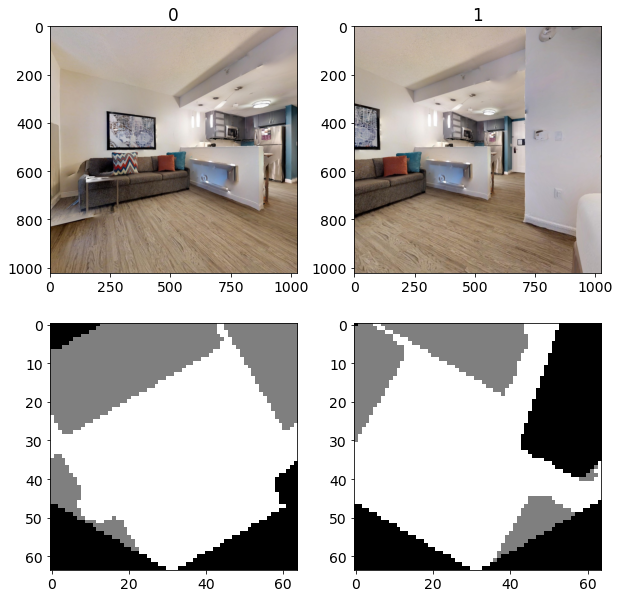

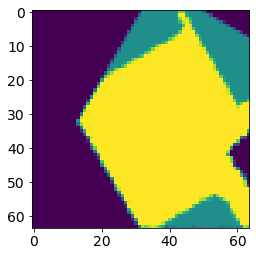

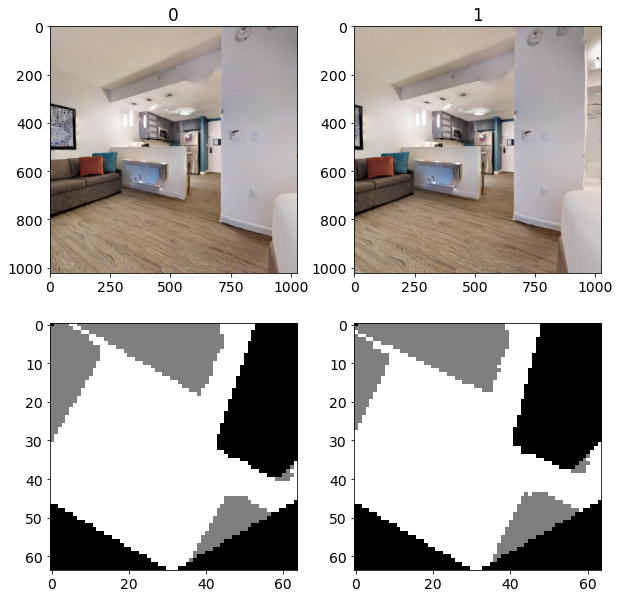

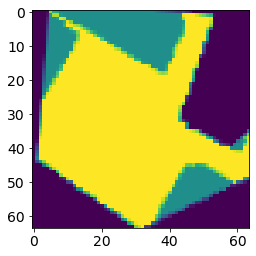

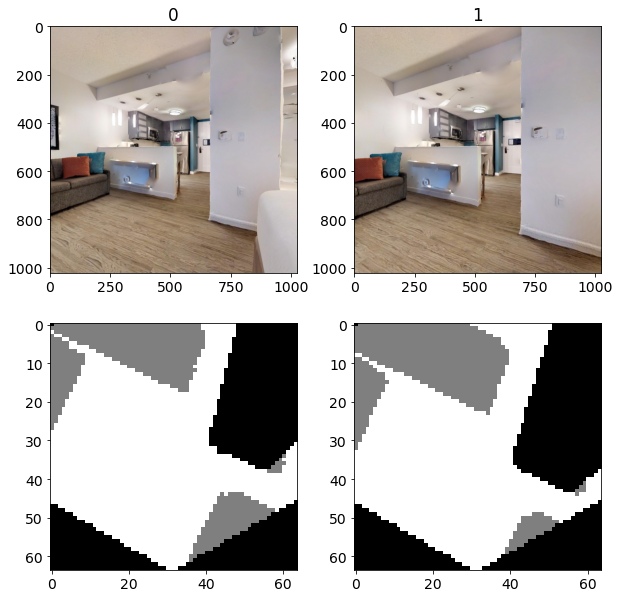

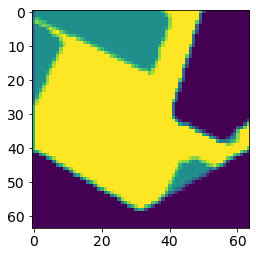

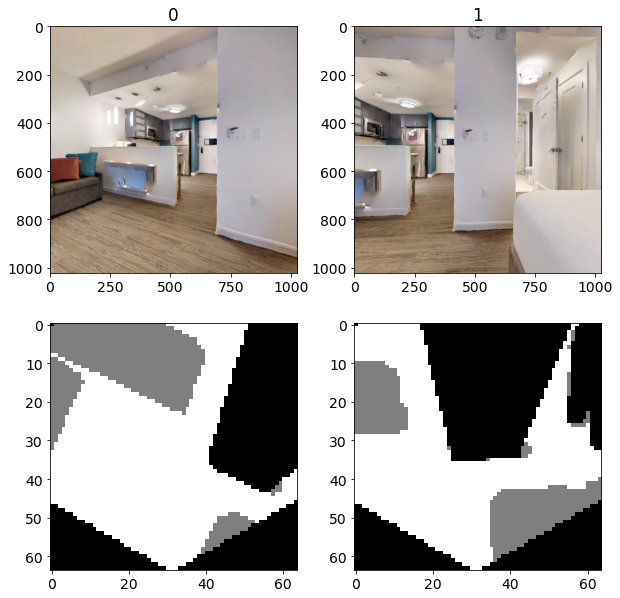

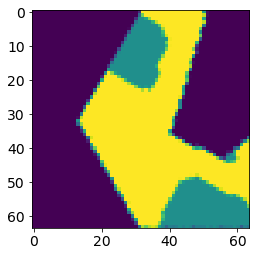

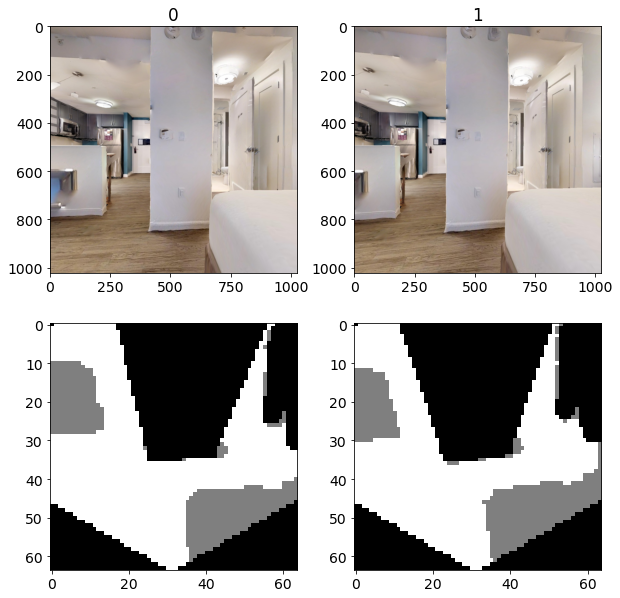

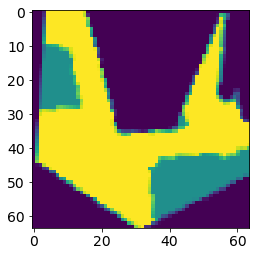

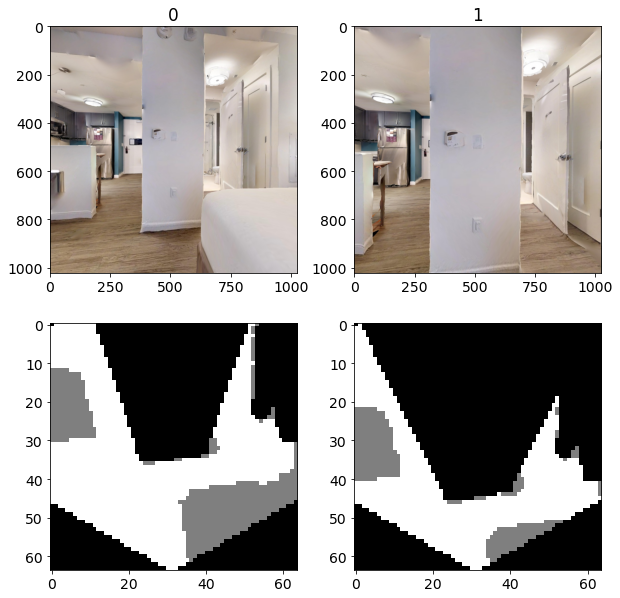

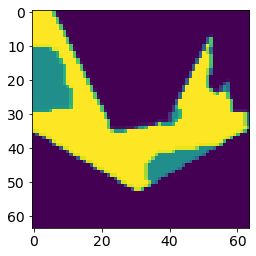

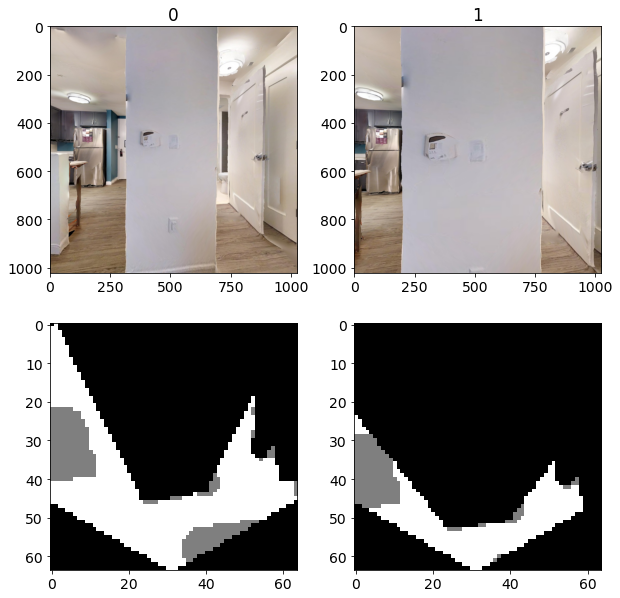

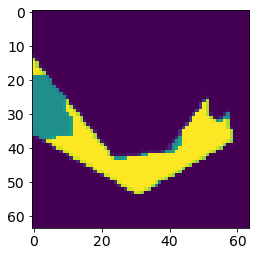

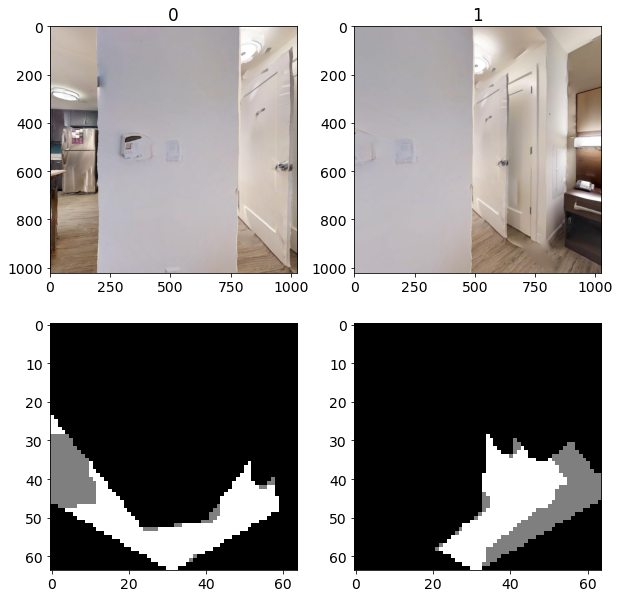

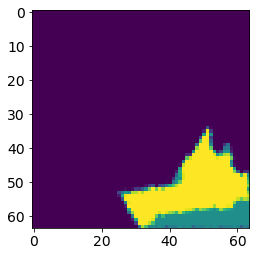

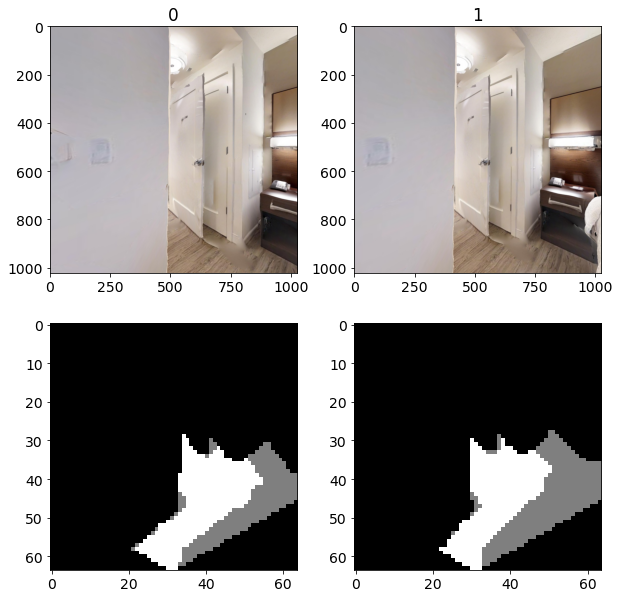

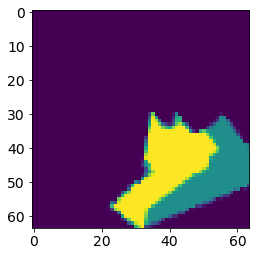

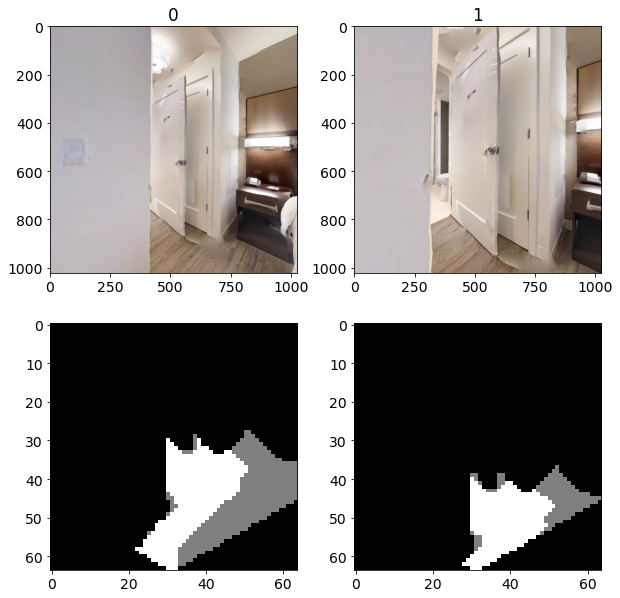

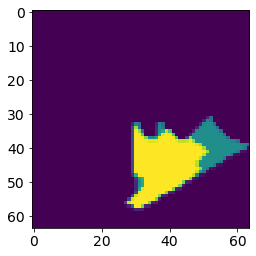

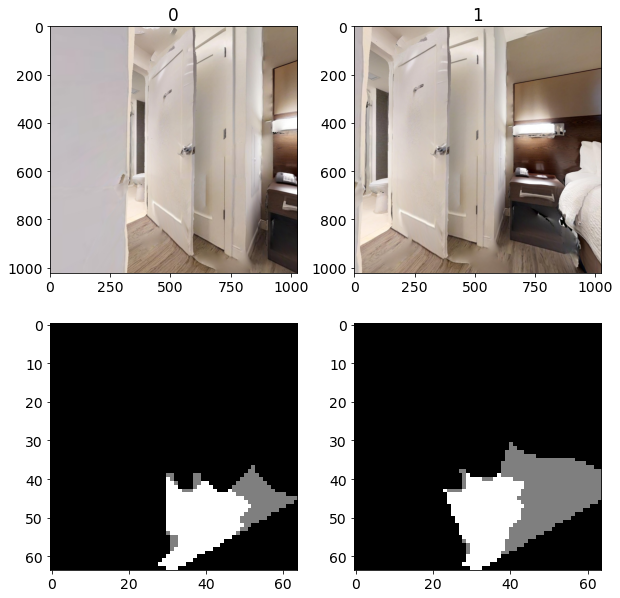

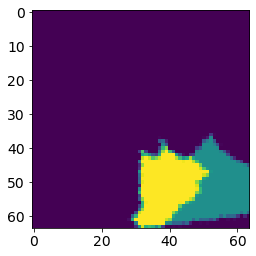

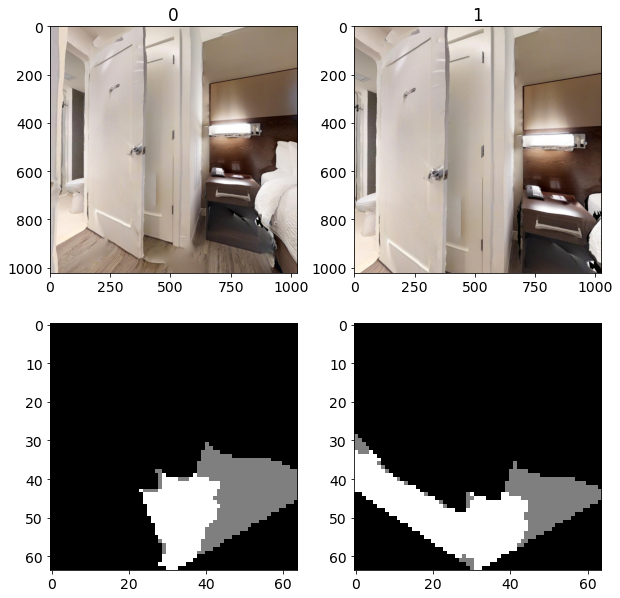

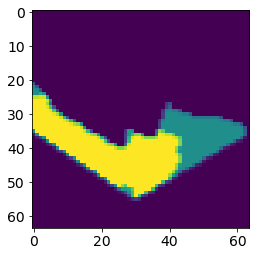

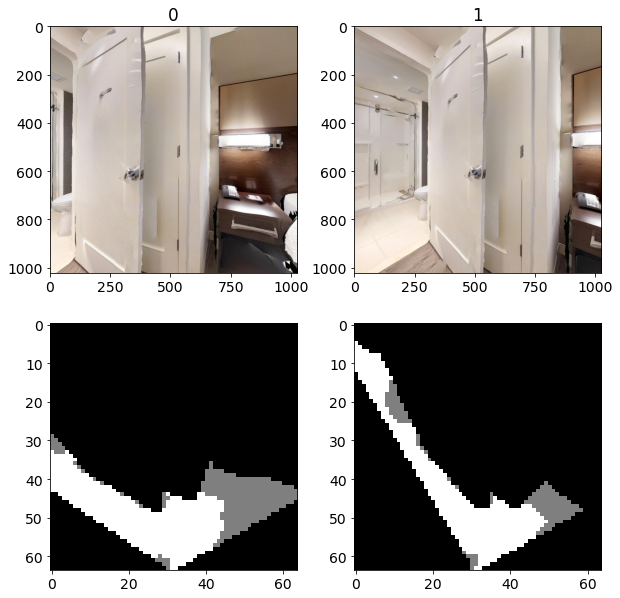

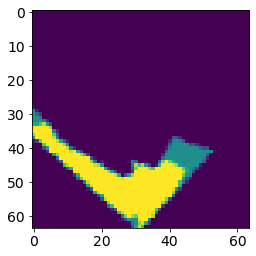

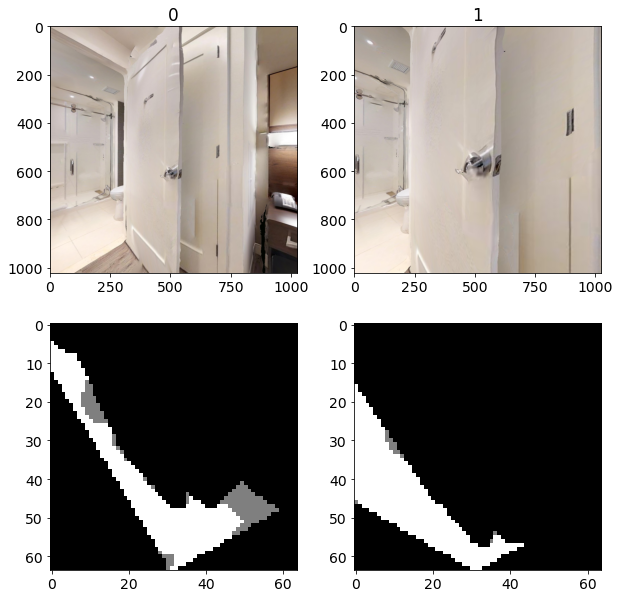

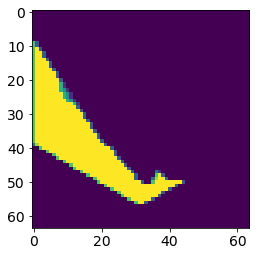

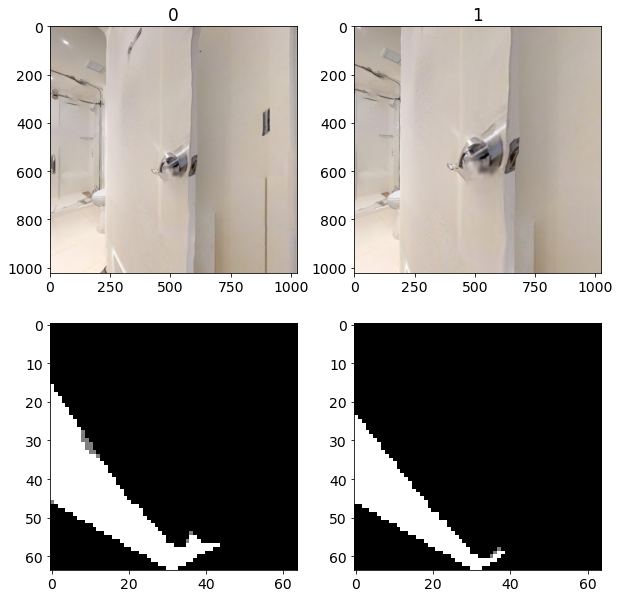

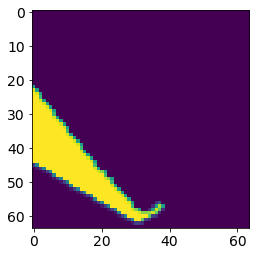

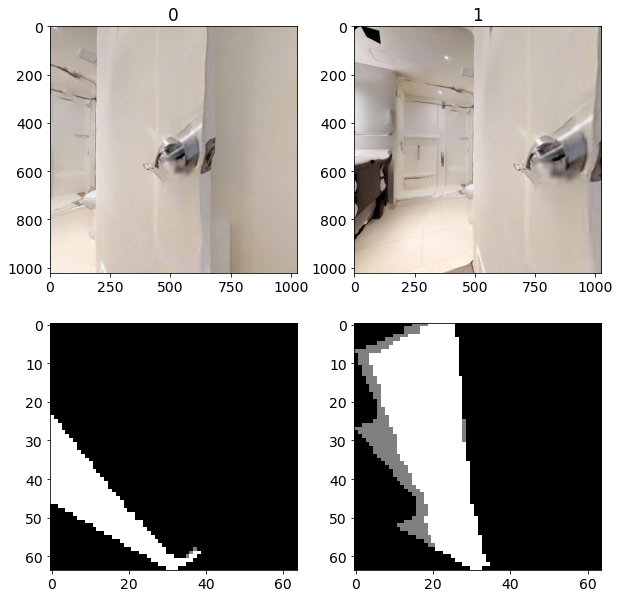

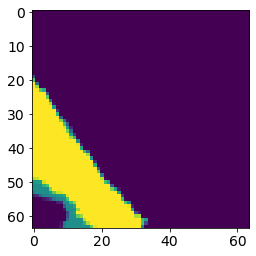

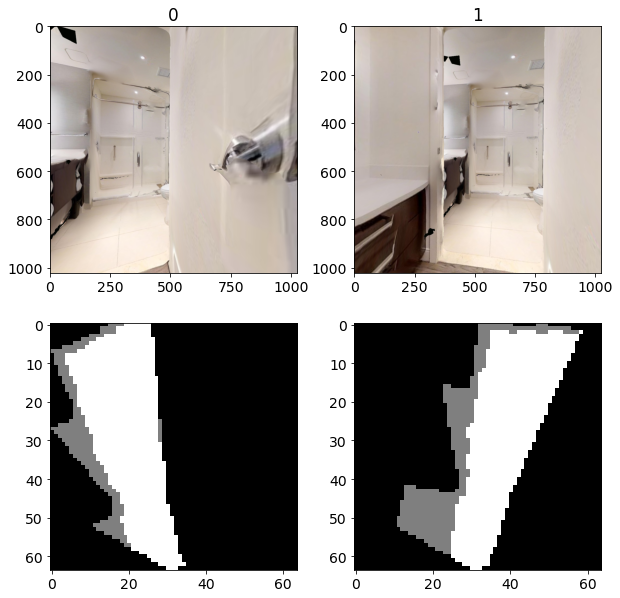

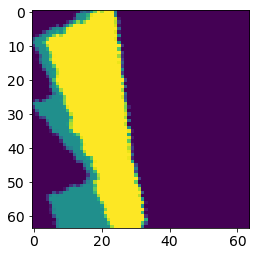

KeyboardInterrupt: 

In [62]:
bev_dir = "/scratch/shantanu/partial_maps/new_partialmaps_120"

# for scene in os.listdir(bev_dir)[0:]:
for scene in ['Eudora']:
    files = os.listdir(os.path.join(bev_dir, scene, "front", "partial_occ"))

    for i in range(2, len(files)-2, 1):
        
#         img_coords = np.array([
#             [64, 32, 1],
#             [64, 0, 1],
#             [0, 0, 1],
#         ])
        
#         img2ego = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]])
#         img2ego = np.array([[-1, 0, 64], [0, 1, -32], [0, 0, 1]])

#         img2ego = np.eye(3)
                
        bevs = [read_bev(i + k, scene) for k in range(-2, 3)]
        poses = [read_pose(i + k, scene) for k in range(-2, 3)]
        rgbs = [read_rgb(i + k, scene) for k in range(-2, 3)]
                
        blank_bev = np.zeros_like(bevs[0])
        
        M = transform_bev(bevs[0], bevs[1], poses[0], poses[1])
        M = np.linalg.inv(M)
#         print("Transform", M)
        
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
        ax[0][0].imshow(rgbs[0])
        ax[1][0].imshow(bevs[0], cmap='gray')
        ax[0][0].set_title('0')
        
        ax[0][1].imshow(rgbs[1])
        ax[1][1].imshow(bevs[1], cmap='gray')
        ax[0][1].set_title('1')
        plt.show()
        
#         transformed_points = (np.linalg.inv(img2ego) @ M() @ img_coords.T
#         plt.plot(transformed_points[0, :], transformed_points[1, :])
#         plt.show()
        
#         affine_mat = (np.linalg.inv(img2ego) @ M)[:2, :]
#         affine_mat[1, -1] *= -1
        
#         rot = cv2.getRotationMatrix2D((blank_bev.shape[1]//2, blank_bev.shape[1]), angle=-30, scale=1)

        affine_mat = M[:2, :]
        warped_bev = cv2.warpAffine(bevs[1], affine_mat, (blank_bev.shape[1], blank_bev.shape[0]))
        plt.imshow(warped_bev)
        plt.show()
        
#         print(np.round(affine_mat, 2))
#         print(np.round(rot, 2))
#         break
        
#         bevs_0 = [transform_bev(bevs[len(bevs)//2], bevs[k], poses[len(bevs)//2], poses[k]) for k in range(-2, 3)]
#         break
    break

In [37]:
M = np.array([
    [0.867, -0.5],
    [0.5, 0.87]
])

M @ np.array([[-64], [32]])

array([[-71.488],
       [ -4.16 ]])

In [ ]:
        for idx, pose in enumerate(poses):
#             print(*pose['position'][[0, 2]])
            plt.scatter(*pose['position'][[0, 2]], label=f"{idx}")
        plt.legend()
        plt.show()
